# Genetic optimization of an adiabatic annealing schedule

D-Wave limitations: 
1. Limited number of points in a given anneal schedule
2. Must be only increasing of flat in time [s(t_2) >= s(t_1)] so no counter-adiabatic driving.
3. Maximum slope specified by the machine.

Our Genetic optimization is compared to the basis s = t/t_f linear schedule. The total anneal time is fixed to 100 mus. We create a population of 20 anneal schedules (individuals). Their genome is the ordered list of points where the slope changes in the anneal schedule. In the initial population, we seed in the linear anneal schedule so that it may compare and benefit from mixing with the others. 

We perform the optimization with N_elite = 2. The breeding method is simply done by finding the geometric mean for each gene is the two parents (an example will be shown below). A mutation rate is included in two different ways: 1) where random genes (anneal points) are slightly shifted upwards or downwards by an amount picked from a gaussian with 0 average and a user specified variance, 2) where an interval between two genes is shrunk (careful with the max slope!). 

Hopefully, it takes less total calls to the machine to optain a lowest energy state. Benchmark is done on a randomly obtained spin glass instance. We plot the log(-E_best) vs iterations, in order to see the convergence to a given ground state that may be the solution to an optimization problem.

# First the d-wave setup

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import math
from dwave.system import DWaveSampler
import minorminer as mm
import dwave.inspector

In [12]:
# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())

#print sampler properties
print("---- Sampler properties ----")
print("QPU {} was selected.".format(sampler.solver.name))
print("Chosen topology is:")
print(sampler.properties["topology"])
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {} (in us)".format(sampler.properties["annealing_time_range"]))
max_slope = 1.0/sampler.properties["annealing_time_range"][0]
print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
print("J range: {}".format(sampler.properties["j_range"]))
print("h range: {}".format(sampler.properties["h_range"]))

---- Sampler properties ----
QPU DW_2000Q_6 was selected.
Chosen topology is:
{'type': 'chimera', 'shape': [16, 16, 4]}
Maximum anneal-schedule points: 12
Annealing time range: [1.0, 2000.0] (in us)
Maximum slope allowed on this solver is 1.00.
J range: [-1.0, 1.0]
h range: [-2.0, 2.0]


12


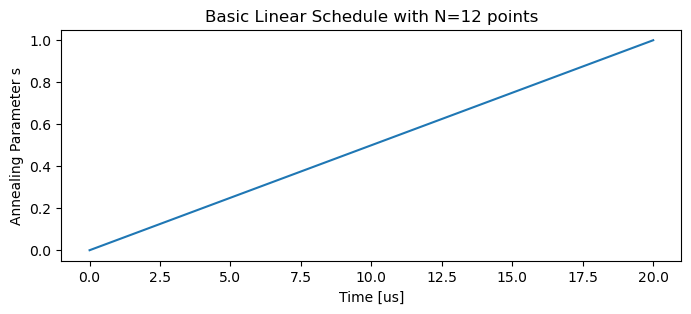

In [551]:
#basic linear anneal schedule (no pause)
max_time = 20
npt = 10
#basic_schedule = [[0.0, 0.0], [100, 1.0]]
basic_schedule = []
basic_schedule.append([0.0, 0.0])
for j in range(1,npt+1):
    basic_schedule.append([max_time*(j/(npt+1)),1*(j/(npt+1))])
basic_schedule.append([max_time, 1.0])
print(len(basic_schedule))

#plot it
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Basic Linear Schedule with N={} points".format(npt+2))
ax.plot([basic_schedule[i][0] for i in range(len(basic_schedule))], [basic_schedule[i][1] for i in range(len(basic_schedule))])
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

In [16]:
#a random problem instance
h = {v: 0.0 for v in sampler.nodelist}
J = {tuple(c): np.random.choice([-1, 1]) for c in sampler.edgelist}

print("Bias 0 assigned to", len(h), "qubits.")
print("Strengths -1/+1 assigned randomly to",len(J),"couplers.")

Bias 0 assigned to 2041 qubits.
Strengths -1/+1 assigned randomly to 5974 couplers.


In [20]:
#a basic forward anneal without optimization
#obtain the results
benchmark_answer = sampler.sample_ising(h, J, 
                                      num_reads=1000, 
                                      anneal_schedule=basic_schedule, 
                                      label='AS - benchmark',
                                      answer_mode='raw')
benchmark_solutions, benchmark_energies = benchmark_answer.record.sample, benchmark_answer.record.energy
#benchmark_solutions, benchmark_energies = forward_solutions, forward_energies
print("QPU time used:", benchmark_answer.info['timing']['qpu_access_time']/10**6, " seconds.")
#last one was 0.5 seconds.

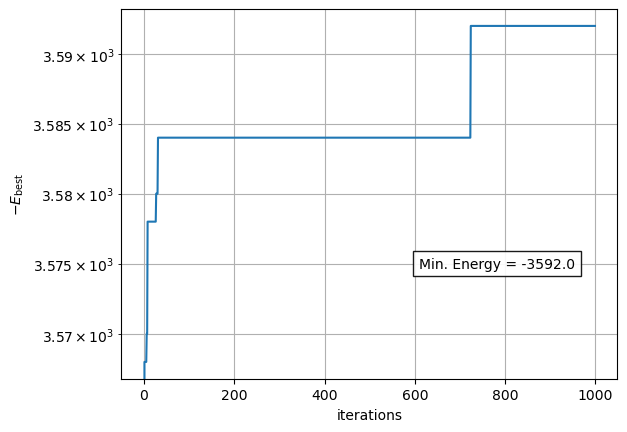

In [41]:
#plot the best result vs iteration:
#extract "fidelity"
nresults = len(forward_energies)
fidelity = np.zeros(nresults)
for i in range(1, len(forward_energies)):
    fidelity[i] = -np.min(forward_energies[:i])

fig, ax = plt.subplots()
ax.plot(fidelity)
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel(r'$-E_{\rm best}$');
ax.grid(True, which='both')
ax.text(0.6, 0.3, 'Min. Energy = {}'.format(-fidelity[-1]), bbox=dict(facecolor='white', alpha=0.9), transform=ax.transAxes)
plt.show()

Note that, in order to *really* benchmark such problems, we would need to run this code multiple times. Note that, even running it 20 times will require 10 seconds out of the available free minute. Therefore, more time would be needed.

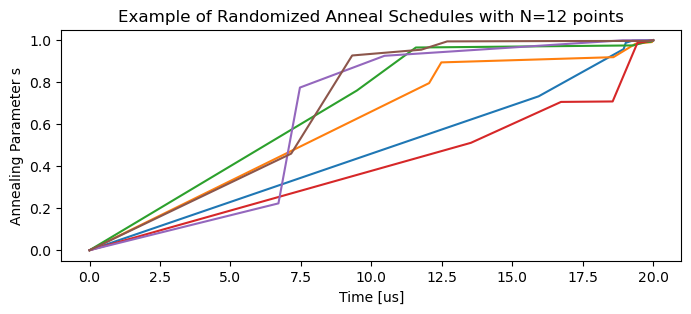

In [537]:
#a random anneal schedule that satisfies the constraints.
def create_random_schedule(npt):
    cond = False
    while cond == False:
        random_schedule = []
        random_schedule.append([0.0, 0.0])
        index_schedule = 0
        for j in range(npt):
            #v1
            rand_t = np.random.uniform(random_schedule[index_schedule][0], max_time)
            delta_t = rand_t - random_schedule[index_schedule][0]
            rand_s = np.random.uniform(random_schedule[index_schedule][1], np.min([1.0, random_schedule[index_schedule][1] + max_slope*delta_t]))
            
            #v2
            #rand_t = np.random.uniform(random_schedule[index_schedule][0], (j+1)*max_time/(npt+1))
            #delta_t = rand_t - random_schedule[index_schedule][0]
            #rand_s = np.random.uniform(random_schedule[index_schedule][1], np.min([(j+1)/(npt+1), random_schedule[index_schedule][1] + max_slope*delta_t]))
                       
            new_anneal_point = [rand_t, rand_s]
            random_schedule.append(new_anneal_point)
            index_schedule +=1

        random_schedule.append([max_time, 1.0])
        #check the final point respects the anneal schedule
        final_delta_t = random_schedule[-1][0] - random_schedule[-2][0]
        final_delta_s = random_schedule[-1][1] - random_schedule[-2][1]
        final_slope = final_delta_s/final_delta_t
        if final_slope < max_slope:
            #the final slope respects the max slope
            cond = True
    return random_schedule

plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Example of Randomized Anneal Schedules with N={} points".format(npt+2))
for j in range(6):
    schedule = create_random_schedule(npt)
    ax.plot(*[[s[i] for s in schedule] for i in [0, 1]], label='instance {}'.format(j))
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

In [538]:
#define the breeding and mutation functions
def breeding(parent1, parent2):
    num_of_points = len(parent1)
    children = []
    children.append([0,0])
    for i in range(1, num_of_points-1):
        children.append([np.mean([parent1[i][0], parent2[i][0]]), np.mean([parent1[i][1], parent2[i][1]])])
    children.append([max_time, 1.0])
    #this child could be problematic!
    return np.array(children)

def mutation(children, mutation_rate):
    num_of_points = len(children)
    #choose a random site to affect
    ind = np.random.randint(1, num_of_points-1)
    new_child = np.copy(children)
    if np.random.rand() < 0.5:
        #mutate a s:
        #shift s(ind) and the
        #either
        #scale downward all s(t) for i < ind
        #scale upward all s(t) for i > ind
        #this is to keep slopes always positive!
        rand_num = children[ind][1]
        prev_val = children[ind][1]
        while True:
            rand_num = np.random.normal(prev_val, mutation_rate)
            if (0 < rand_num < 1):
                break
                
        if rand_num > prev_val:
            for q in range(ind, num_of_points):
                new_child[q][1] = 1 - (1 - children[q][1])*(1-rand_num)/(1 - prev_val)
        elif rand_num < prev_val:
            for q in range(0, ind):
                new_child[q][1] = (children[q][1])*(rand_num)/(prev_val)            
    else:
        #mutate a t
        rand_num = children[ind][0]
        while True:
            rand_num = np.random.normal(children[ind][0], max_time*mutation_rate)
            if children[ind-1][0] <= rand_num <= children[ind+1][0]:
                break
        new_child[ind][0] = rand_num
    return np.array(new_child)

def check_anneal_schedule_slopes(individual):
    check = 0
    keep = True
    for i in range(1,len(individual)):
        delta_t = individual[i][0] - individual[i-1][0]
        delta_s = individual[i][1] - individual[i-1][1]
        slope = delta_s/delta_t
        if slope > max_slope or slope < 0:
            #print("slope = {}, delta_t = {}, delta_s = {}".format(slope, delta_t, delta_s))
            check += 1 #problem!

    if check != 0: #there was a problematic slope
        keep = False
    return keep

def evaluate_function(population, num_reads = 10):
    evals = np.zeros((len(population), num_reads))
    min_ene = np.zeros(len(population))
    min_config = np.zeros((len(population), len(h)))
    timing = 0
    for p in range(len(population)):
        answer = sampler.sample_ising(h, J, 
                                      num_reads=num_reads, 
                                      anneal_schedule=population[p], 
                                      label='AS - random - {}'.format(p),
                                      answer_mode='raw')
        evals[p,:] = answer.record.energy
        min_ene[p] = np.min(answer.record.energy)
        min_config[p,:] = answer.record.sample[np.argmin(answer.record.energy)]
        timing += answer.info['timing']['qpu_access_time']/10**6
    return evals, min_ene, min_config, timing

def new_population(population, fidelity, N_elite, mutation_rate):
    #mutation_rate = [% of child that mutation, sigma of the mutation]
    N = len(population)
    #fidelity
    scaled_fidelity = (np.max(fidelity) - fidelity)/(np.max(fidelity) - np.min(fidelity))
    #sort them
    sorted_fidelity = np.argsort(fidelity) #this gives you the indices of the lowest fidelity to the highest - we are trying to minimize F
    #make scaled fidelity into a probability distribution
    prob_fidelity = scaled_fidelity/np.sum(scaled_fidelity)
    #choose a member for crossover, based on fitness
    #np.random.choice(np.arange(0,len(population),1, dtype=int), p=prob_fidelity)

    #number of elites is N_elite
    new_population = np.copy(population)
    #always keep the benchmark anneal as the first item
    count = 1
    #hence, count starts at 1
    #then keep the elite ones
    for i in range(N_elite):
        ind_elite = sorted_fidelity[i]
        new_population[count] = population[ind_elite]
        count += 1

    #note that the elite *might* also be the linear schedule. 
    #That's ok, it just means we do more annealings of the good schedule!

    #add children
    while count < N:
        #select pairs of parents
        cond_parents = True
        while cond_parents:
            #select pairs based on a fidelity probability distribution, where the best ones are chosen more frequently
            selected = np.random.choice(N,2,p=prob_fidelity)
            if selected[0] != selected[1]: #parents need to be different!
                cond_parents = False
            else:
                cond_parents = True

        #breed the parents to obtain child
        to_be_added = breeding(population[selected[0]], population[selected[1]])
        #sometimes, mutate the child
        if np.random.rand() < mutation_rate[0]:
            to_be_added = mutation(to_be_added, mutation_rate[1])

        #if the new anneal schedule (the mutated child) violates the constraint
        #do not include it
        #and start again!
        if check_anneal_schedule_slopes(to_be_added):
            #check if this individual is dead already (i.e. does not satisfy the anneal schedule constraint)
            new_population[count] = to_be_added
            count += 1

    return new_population



good anneal? True


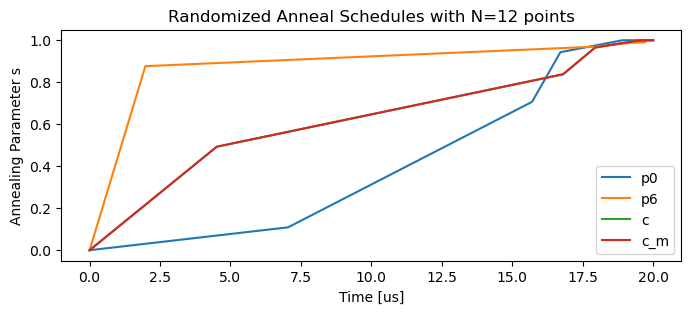

In [541]:
#test the breeding of two individuals and the mutation
ind1 = 1
ind2 = 9
child = breeding(np.array(population[ind1]), np.array(population[ind2]))
#child2 = population[9]
child2 = mutation(child, 0.2)
print("good anneal? {}".format(check_anneal_schedule_slopes(child2)))
plot_population([np.array(population[ind1]), np.array(population[ind2]), child, child2], ['p0','p6','c', 'c_m'])

# The Genetic algorithm itself

In [547]:
#make initial population of anneal_schedules
population = []
population.append(basic_schedule)
for j in range(10):
    population.append(create_random_schedule(npt))
population = np.array(population)
#define the genetic algorithm terms
Npop = len(population)
N_elite = 1 #keep one elite as well as the linear benchmark, at all times.
mutation_rate = [0.3, 0.1] #[no. of times an individual is chosen to mutation, variance of mutation]


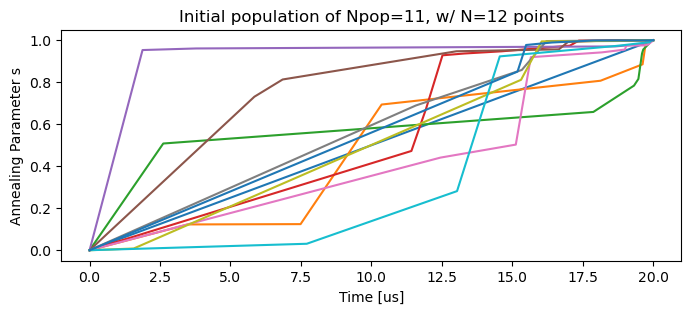

In [548]:
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Initial population of Npop={}, w/ N={} points".format(Npop, npt+2))
for j in range(len(population)):
    schedule = population[j]
    plot_label = 'instance {}'.format(j)
    ax.plot([schedule[i][0] for i in range(len(schedule))], [schedule[i][1] for i in range(len(schedule))], label=plot_label)
#plt.legend()
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

In [549]:
iteration = 1
maxiter = 20
n_reads = 50
kept_fidelity = np.zeros((maxiter, Npop))
kept_best_state = np.zeros((maxiter, len(h)))
total_time_used = 0
#initial fidelity
all_ene, fidelity, all_configs, timing = evaluate_function(population, num_reads = n_reads)
#fidelity is already declared above
total_time_used += timing

while iteration < maxiter:
    population = new_population(population, fidelity, N_elite, mutation_rate)
    all_ene, fidelity, all_config, timing = evaluate_function(population, num_reads = 50)
    total_time_used += timing
    kept_fidelity[iteration] = np.sort(fidelity)
    kept_best_state[iteration] = all_config[np.argmin(fidelity)]
    print("done w/ iteration {}, best fidelity = {}".format(iteration,np.min(fidelity)))
    print("total calls to the D-Wave sampler:{}".format(iteration*Npop*10))
    print("QPU time used {}".format(total_time_used))
    iteration += 1
    if total_time_used > 10:
        break

done w/ iteration 1, best fidelity = -3582.0
total calls to the D-Wave sampler:110
QPU time used 0.6964698199999999
done w/ iteration 2, best fidelity = -3588.0
total calls to the D-Wave sampler:220
QPU time used 1.04477223
done w/ iteration 3, best fidelity = -3578.0
total calls to the D-Wave sampler:330
QPU time used 1.39302964
done w/ iteration 4, best fidelity = -3578.0
total calls to the D-Wave sampler:440
QPU time used 1.74133205
done w/ iteration 5, best fidelity = -3582.0
total calls to the D-Wave sampler:550
QPU time used 2.08958946
done w/ iteration 6, best fidelity = -3584.0
total calls to the D-Wave sampler:660
QPU time used 2.43789187
done w/ iteration 7, best fidelity = -3582.0
total calls to the D-Wave sampler:770
QPU time used 2.78619428
done w/ iteration 8, best fidelity = -3582.0
total calls to the D-Wave sampler:880
QPU time used 3.13445169
done w/ iteration 9, best fidelity = -3586.0
total calls to the D-Wave sampler:990
QPU time used 3.4827541
done w/ iteration 10,

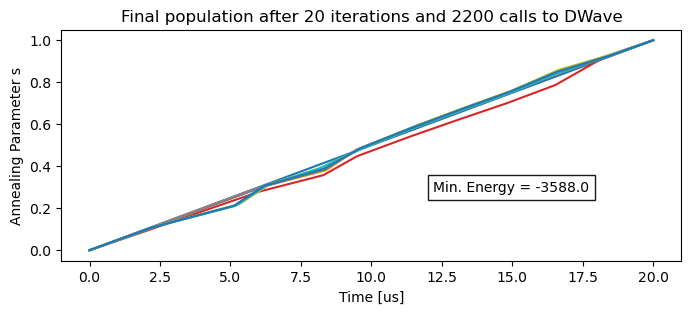

In [550]:
#plotting the final results

plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Final population after {} iterations and {} calls to DWave".format(iteration, iteration*Npop*10))
for j in range(len(population)):
    schedule = population[j]
    plot_label = 'instance {}'.format(j)
    ax.plot([schedule[i][0] for i in range(len(schedule))], [schedule[i][1] for i in range(len(schedule))], label=plot_label)
#plt.legend()
ax.text(0.6, 0.3, 'Min. Energy = {}'.format(np.min(kept_fidelity)), bbox=dict(facecolor='white', alpha=0.9), transform=ax.transAxes)
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

# Population plotting function

In [497]:
#plot the population
def plot_population(population_into, labels = None):
    plt.figure(figsize=(8, 3))
    ax = plt.gca()
    ax.set_title("Randomized Anneal Schedules with N={} points".format(npt+2))
    for j in range(len(population_into)):
        schedule = population_into[j]
        if labels == None:
            plot_label = 'instance {}'.format(j)
        else:
            plot_label = labels[j]
        ax.plot([schedule[i][0] for i in range(len(schedule))], [schedule[i][1] for i in range(len(schedule))], label=plot_label)
    plt.legend()
    plt.xlabel('Time [us]')
    plt.ylabel('Annealing Parameter s')
    plt.show()

# Example

In [81]:
#example of 10 reads with a random schedule
answer = sampler.sample_ising(h, J, 
                                      num_reads=10, 
                                      anneal_schedule=create_random_schedule(npt), 
                                      label='AS - random',
                                      answer_mode='raw')
#benchmark_solutions, benchmark_energies = forward_solutions, forward_energies
print("QPU time used:", answer.info['timing']['qpu_access_time']/10**6, " seconds.")
print("lowest energy = {}".format(np.min(answer.record.energy)))

QPU time used: 0.016855909999999998  seconds.
lowest energy = -3580.0
